In [ ]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
images[0].save("fantasy_landscape.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True,
)

prompt = "a photo of an astronaut riding a horse on mars"
pipe.enable_attention_slicing()
image = pipe(prompt).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/25 [00:00<?, ?it/s]

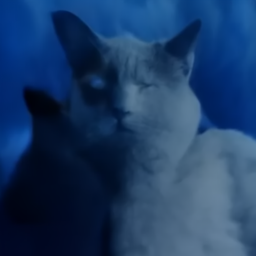

In [ ]:
from diffusers import DDPMPipeline

# Try loading the model without specifying use_safetensors,
# allowing it to use the default weights format if safetensors are not available.
ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

# **Load the Model and scheduler**

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [ ]:
scheduler.set_timesteps(50)

In [ ]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [ ]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

In [ ]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

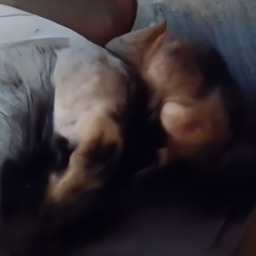

In [ ]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
prompt = ["a healthy fluffy boy in VIT doing design"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [ ]:
import torch
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
    DiffusionPipeline,
)

class StableDiffusionCustomPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: UniPCMultistepScheduler,
    ):
        super().__init__()
        # The set_format method is not available for UniPCMultistepScheduler.
        # It is typically used with schedulers like DDPMScheduler.
        # Remove the following line:
        # scheduler = scheduler.set_format("pt")

        # Instead, you can set the format directly in the scheduler's config:
        scheduler.config.prediction_type = "epsilon"  # or "v_prediction" depending on your model
        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
        )
    # ... (rest of the code remains the same)

    @torch.no_grad()
    def __call__(
        self,
        prompt: str,
        height: int = 512,
        width: int = 512,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        generator: torch.Generator = None,
    ):
        # 1. Encode input prompt
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # 2. Create classifier-free guidance inputs
        do_classifier_free_guidance = guidance_scale > 1.0
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer(
                [""],
                padding="max_length",
                max_length=max_length,
                return_tensors="pt",
            )
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # 3. Create initial random noise
        latents = torch.randn(
            (1, self.unet.in_channels, height // 8, width // 8),
            generator=generator,
            device=self.device,
        )

        # 4. Set timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        # 5. Denoising loop
        for t in self.scheduler.timesteps:
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents).prev_sample

        # 6. Decode the image latents with the vae
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]

        # 7. Convert to PIL
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        image = [Image.fromarray(i) for i in image]

        return {"sample": image[0]}  # Return the first image from the batch

In [ ]:
kfrom diffusers import AutoencoderKL, UNet2DConditionModel, UniPCMultistepScheduler
from transformers import CLIPTextModel, CLIPTokenizer

# Load the components
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True)
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# Create the custom pipeline
pipe = StableDiffusionCustomPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
).to("cuda")

# Generate an image
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt, generator=torch.Generator(device="cuda").manual_seed(0))["sample"]
image.save("astronaut_horse.png")

<ipython-input-38-fdf69eab1a7a>:72: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, self.unet.in_channels, height // 8, width // 8),


# **Using GPT to help me build a DAE- Denoising AutoEncoder**

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
import cv2

# Load CIFAR-10 dataset (example)
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add Gaussian noise
def add_noise(images, mean=0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = images + noise
    return np.clip(noisy_images, 0, 1)  # Clip values to valid range

noisy_x_train = add_noise(x_train)
noisy_x_test = add_noise(x_test)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define the encoder
input_img = Input(shape=(32, 32, 3))  # Input image shape
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Define the decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define the full model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
autoencoder.fit(
    noisy_x_train, x_train,  # Input: Noisy images, Output: Clean images
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_x_test, x_test)
)

# Save the trained model
autoencoder.save('denoising_autoencoder.h5')


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0217 - val_loss: 0.0073
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


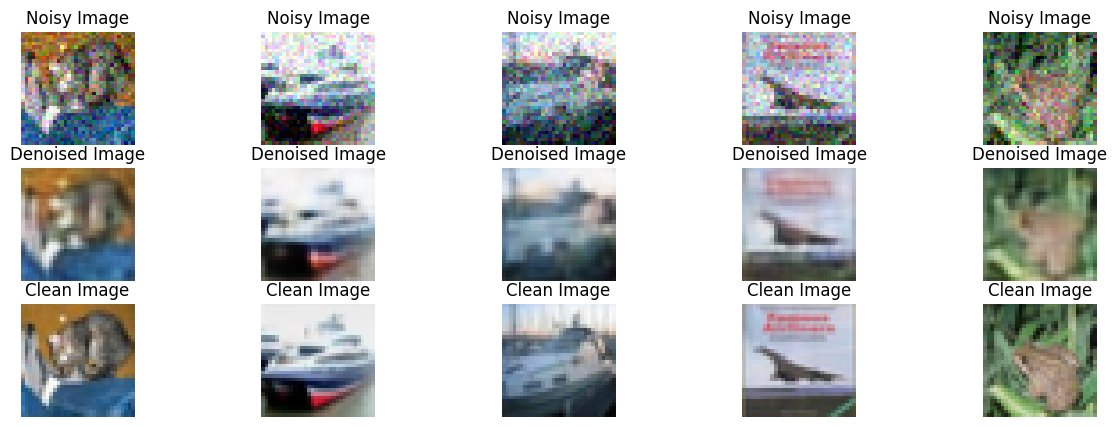

In [ ]:
import matplotlib.pyplot as plt

# Test on noisy images
decoded_imgs = autoencoder.predict(noisy_x_test)

# Display results
n = 5  # Number of images to display
plt.figure(figsize=(15, 5))
for i in range(n):
    # Display noisy image
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_x_test[i])
    plt.title("Noisy Image")
    plt.axis('off')

    # Display denoised image
    plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised Image")
    plt.axis('off')

    # Display original clean image
    plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(x_test[i])
    plt.title("Clean Image")
    plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
import random

def add_scratch(image, num_lines=10):
    # Create a blank mask
    mask = np.zeros_like(image, dtype=np.uint8)

    # Add random lines (scratches) to the mask
    for _ in range(num_lines):
        x1, y1 = random.randint(0, image.shape[1]), random.randint(0, image.shape[0])
        x2, y2 = random.randint(0, image.shape[1]), random.randint(0, image.shape[0])
        thickness = random.randint(1, 3)
        cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), thickness)

    # Combine the original image and the mask
    scratched_image = cv2.addWeighted(image, 1, mask, 0.3, 0)
    return scratched_image, mask

# Load an image
image = cv2.imread('/content/suit.jpg')

# Add scratches
scratched_image, scratch_mask = add_scratch(image)

# Save results
cv2.imwrite('scratched_image.jpg', scratched_image)
cv2.imwrite('scratch_mask.jpg', scratch_mask)


True

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    # Decoder
    up1 = UpSampling2D((2, 2))(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv2)

    return Model(inputs, outputs)

unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Fit U-Net
unet.fit(scratched_images, scratch_masks, epochs=10, batch_size=8, validation_split=0.2)


NameError: name 'scratched_images' is not defined

In [ ]:
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split

# Paths to save images and masks
output_dir = "synthetic_dataset"
os.makedirs(f"{output_dir}/images", exist_ok=True)
os.makedirs(f"{output_dir}/masks", exist_ok=True)

def add_scratch(image, num_lines=10):
    """
    Add synthetic scratches to an image.
    Returns:
      - Scratched image
      - Scratch mask
    """
    mask = np.zeros_like(image, dtype=np.uint8)
    for _ in range(num_lines):
        x1, y1 = random.randint(0, image.shape[1]), random.randint(0, image.shape[0])
        x2, y2 = random.randint(0, image.shape[1]), random.randint(0, image.shape[0])
        thickness = random.randint(1, 3)
        cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), thickness)
    scratched_image = cv2.addWeighted(image, 1, mask, 0.3, 0)
    return scratched_image, mask

def create_dataset(images, output_dir, num_augmented=5):
    """
    Create a synthetic dataset by adding scratches to clean images.
    """
    for i, img_path in enumerate(images):
        image = cv2.imread(img_path)
        image = cv2.resize(image, (256, 256))  # Resize for consistency
        for j in range(num_augmented):
            scratched, mask = add_scratch(image)
            cv2.imwrite(f"{output_dir}/images/scratched_{i}_{j}.jpg", scratched)
            cv2.imwrite(f"{output_dir}/masks/mask_{i}_{j}.jpg", mask)

# Replace this with paths to your clean image dataset
clean_images = [f"clean_dataset/{img}" for img in os.listdir("clean_dataset")]

# Generate scratched images and masks
create_dataset(clean_images, output_dir)


FileNotFoundError: [Errno 2] No such file or directory: 'clean_dataset'

USING a KAGGLE dataset


In [ ]:
pip install numpy opencv-python scikit-learn tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Set dataset paths
clean_images_path = "/content/dataset_folder/landscape Images/color"
scratched_images_path = "/content/dataset_folder/landscape Images/gray"

# Load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (256, 256))
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

clean_images = load_images_from_folder(clean_images_path)
scratched_images = load_images_from_folder(scratched_images_path)

# Generate synthetic masks for scratched images
def generate_scratch_masks(images):
    masks = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        mask = mask / 255.0  # Normalize to [0, 1]
        masks.append(np.expand_dims(mask, axis=-1))
    return np.array(masks)

scratch_masks = generate_scratch_masks(scratched_images)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(scratched_images, scratch_masks, test_size=0.2, random_state=42)

# Define U-Net model
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    # Decoder
    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    up7 = UpSampling2D((2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    up8 = UpSampling2D((2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    up9 = UpSampling2D((2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs, conv10)
    return model

# Compile model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=8)

# Save model
model.save('scratch_detection_unet.h5')

# Example of using the trained model for prediction
def predict_scratch_mask(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img)[0]
    return pred_mask

# Predict and visualize
test_image_path = ""
predicted_mask = predict_scratch_mask(test_image_path, model)
cv2.imshow('Predicted Scratch Mask', predicted_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\baber\\Desktop\\VIT\\Revive AI\\archive\\landscape Images\\cleaned_images'

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Extract dataset from Google Drive
!unzip -q /content/drive/MyDrive/archive.zip -d /content/dataset_folder

# Define paths to scratched and clean images
scratched_images_path = '/content/dataset_folder/scratched_images'
clean_images_path = '/content/dataset_folder/cleaned_images'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Only trying 500 training dataset

In [ ]:
import random
import cv2
import numpy as np

# Load a limited number of images from a folder
def load_images_from_folder(folder, num_samples=500):
    files = os.listdir(folder)
    random.shuffle(files)  # Shuffle to ensure random sampling
    images = []
    for filename in files[:num_samples]:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (256, 256)) / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

clean_images_path = "/content/dataset_folder/landscape Images/color"
scratched_images_path = "/content/dataset_folder/landscape Images/gray"

# Load limited datasets
scratched_images = load_images_from_folder(scratched_images_path, num_samples=500)
clean_images = load_images_from_folder(clean_images_path, num_samples=500)


In [ ]:
def generate_scratch_masks(images):
    masks = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        mask = mask / 255.0  # Normalize to [0, 1]
        masks.append(np.expand_dims(mask, axis=-1))
    return np.array(masks)

# Generate masks
scratch_masks = generate_scratch_masks(scratched_images)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data
x_train, x_val, y_train, y_val = train_test_split(scratched_images, scratch_masks, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    # Decoder
    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    up7 = UpSampling2D((2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    up8 = UpSampling2D((2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    up9 = UpSampling2D((2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs, conv10)
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=8)

# Save the trained model to Google Drive
model.save('/content/drive/MyDrive/scratch_detection_unet.h5')


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 695ms/step - accuracy: 0.7027 - loss: 0.5454 - val_accuracy: 0.8697 - val_loss: 0.2942
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 291ms/step - accuracy: 0.8808 - loss: 0.2742 - val_accuracy: 0.9015 - val_loss: 0.2230
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 300ms/step - accuracy: 0.9026 - loss: 0.2270 - val_accuracy: 0.9281 - val_loss: 0.1767
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 307ms/step - accuracy: 0.9261 - loss: 0.1779 - val_accuracy: 0.9330 - val_loss: 0.1633
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - accuracy: 0.9452 - loss: 0.1387 - val_accuracy: 0.9526 - val_loss: 0.1175
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 307ms/step - accuracy: 0.9527 - loss: 0.1167 - val_accuracy: 0.9466 - val_loss: 0.1236
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 305ms/step - accuracy: 0.9548 - loss: 0.1107 - val_accuracy: 0.9626 - val_loss: 0.0949
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.9613 - loss: 0.0964 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


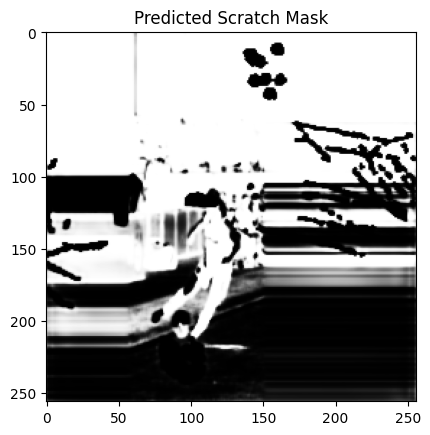

In [ ]:
def predict_scratch_mask(image_path, model):
    """Predicts the scratch mask for an image.

    Args:
      image_path: The path to the image.
      model: The trained U-Net model.

    Returns:
      The predicted scratch mask.
    """

    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return None  # or raise an exception

    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    pred_mask = model.predict(img)[0]
    return pred_mask

# Test prediction
test_image_path = '/content/dataset_folder/landscape Images/gray/1001.jpg'
predicted_mask = predict_scratch_mask(test_image_path, model)

# Check if prediction was successful
if predicted_mask is not None:
    # Visualize the mask
    import matplotlib.pyplot as plt
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title('Predicted Scratch Mask')
    plt.show()

In [ ]:
# Define paths for scratched and clean images
scratched_images_path = '/content/dataset_folder/landscape Images/gray'
clean_images_path = '/content/dataset_folder/landscape Images/color'

In [ ]:
import os
def load_images(folder, num_samples=500):
    files = os.listdir(folder)
    files = files[:num_samples]  # Use only the first `num_samples` files
    images = []
    for filename in files:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (256, 256)) / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load images
scratched_images = load_images(scratched_images_path, num_samples=500)
clean_images = load_images(clean_images_path, num_samples=500)

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset_folder/landscape Images/gray'

In [ ]:
# Split data
x_train, x_val, y_train, y_val = train_test_split(scratched_images, clean_images, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    # Decoder
    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    up7 = UpSampling2D((2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    up8 = UpSampling2D((2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    up9 = UpSampling2D((2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)  # Output 3 channels for RGB image reconstruction
    model = Model(inputs, conv10)
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])


In [ ]:
# Train the U-Net model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=8)

# Save the trained model
model.save('/content/drive/MyDrive/scratch_removal_unet.h5')


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.8149 - loss: 0.0046 - val_accuracy: 0.8153 - val_loss: 0.0041
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step - accuracy: 0.8044 - loss: 0.0039 - val_accuracy: 0.7799 - val_loss: 0.0038
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - accuracy: 0.8076 - loss: 0.0036 - val_accuracy: 0.8197 - val_loss: 0.0036
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - accuracy: 0.7866 - loss: 0.0033 - val_accuracy: 0.8029 - val_loss: 0.0033
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step - accuracy: 0.8121 - loss: 0.0032 - val_accuracy: 0.8292 - val_loss: 0.0030
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - accuracy: 0.8213 - loss: 0.0028 - val_accuracy: 0.8513 - val_loss: 0.0032
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 308ms/step - accuracy: 0.8344 - loss: 0.0031 - val_accuracy: 0.8173 - val_loss: 0.0028
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 310ms/step - accuracy: 0.8080 - loss: 0.0026 - val_accu

In [ ]:
def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
test_image_path = '/content/dataset_folder/landscape Images/gray/11072.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()


NameError: name 'cv2' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


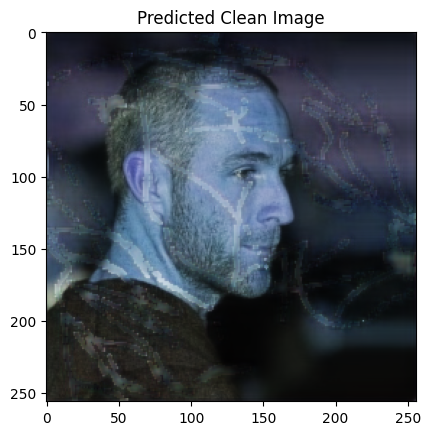

In [ ]:
def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
test_image_path = '/content/dataset_folder/landscape Images/gray/1118.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


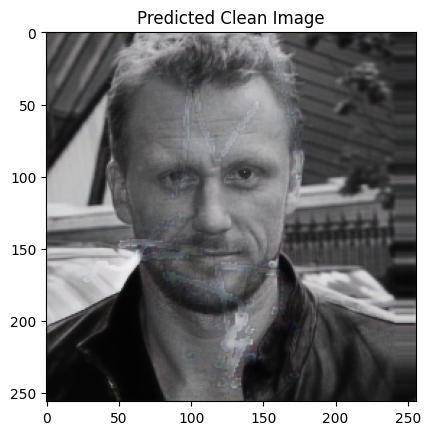

In [ ]:
def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
test_image_path = '/content/dataset_folder/landscape Images/gray/11186.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()


In [ ]:
def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
test_image_path = '/content/dataset_folder/landscape Images/gray/11267.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()


NameError: name 'model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


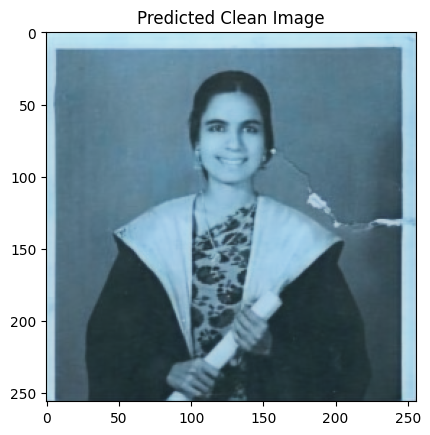

In [ ]:
def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
test_image_path = '/dadiji_test_scratched.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()


In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [4]:

def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
model = '/content/drive/MyDrive/scratch_removal_unet.h5'
test_image_path = '/content/dataset_folder/landscape Images/gray/1118.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


# **Since the above one has a model that fell into overfitting, retraining it for 500 more samples**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip -q "/content/drive/MyDrive/archive.zip" -d "/content/dataset_folder"


Mounted at /content/drive


In [ ]:
# Define paths for scratched and clean images
scAratched_images_path = '/content/dataset_folder/landscape Images/gray'
clean_images_path = '/content/dataset_folder/landscape Images/color'

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Load a subset of images ( 1000 samples)
def load_images(folder, num_samples=1000):
    files = os.listdir(folder)
    files = files[:num_samples]  # Use only the first `num_samples` files
    images = []
    for filename in files:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (256, 256)) / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load images
scratched_images = load_images(scratched_images_path, num_samples=1000)
clean_images = load_images(clean_images_path, num_samples=1000)

In [ ]:
# Split data
x_train, x_val, y_train, y_val = train_test_split(scratched_images, clean_images, test_size=0.2, random_state=42)


# **Defining U-net**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2))(conv4)
    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    # Decoder
    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    up7 = UpSampling2D((2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    up8 = UpSampling2D((2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    up9 = UpSampling2D((2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)  # Output 3 channels for RGB image reconstruction
    model = Model(inputs, conv10)
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['accuracy'])


# Training the **model**

In [ ]:
# Train the U-Net model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=8)

# Save the trained model
model.save('/content/drive/MyDrive/scratch_removal_test2.h5')


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 485ms/step - accuracy: 0.4751 - loss: 0.0467 - val_accuracy: 0.5702 - val_loss: 0.0147
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.6705 - loss: 0.0124 - val_accuracy: 0.7077 - val_loss: 0.0090
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step - accuracy: 0.7215 - loss: 0.0094 - val_accuracy: 0.7021 - val_loss: 0.0082
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.7445 - loss: 0.0076 - val_accuracy: 0.7529 - val_loss: 0.0053
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.7512 - loss: 0.0056 - val_accuracy: 0.8570 - val_loss: 0.0043
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 311ms/step - accuracy: 0.7794 - loss: 0.0046 - val_accuracy: 0.7990 - val_loss: 0.0046
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.7845 - loss: 0.0040 - val_accuracy: 0.7832 - val_loss: 0.0032
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.7935 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


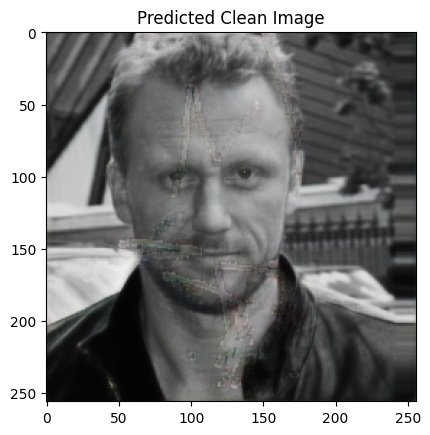

In [ ]:
def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
test_image_path = '/content/dataset_folder/landscape Images/gray/11186.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


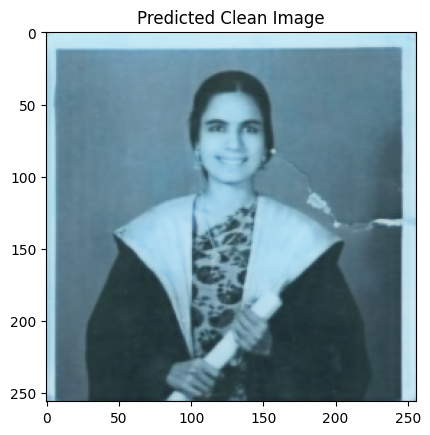

In [ ]:
def predict_clean_image(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256)) / 255.0
    img = np.expand_dims(img, axis=0)
    predicted_clean = model.predict(img)[0]
    return predicted_clean

# Test prediction
test_image_path = '/dadiji_test_scratched.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


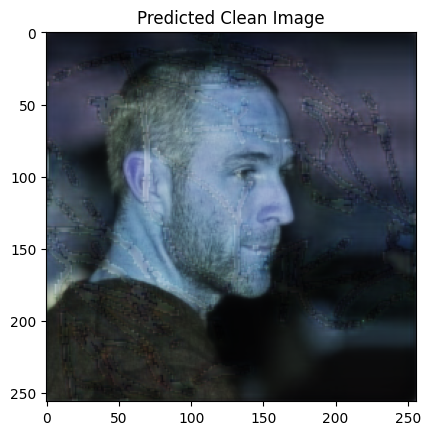

In [ ]:
# Test prediction
test_image_path = '/content/dataset_folder/landscape Images/gray/1118.jpg'
predicted_clean = predict_clean_image(test_image_path, model)

# Visualize the result
import matplotlib.pyplot as plt
plt.imshow(predicted_clean)
plt.title('Predicted Clean Image')
plt.show()


Loading the Model from HuggingFace and providing Before/After

In [6]:
from huggingface_hub import hf_hub_download
from tensorflow.keras.models import load_model

# Download model from Hugging Face Hub
model_path = hf_hub_download(
    repo_id="Sami-on-hugging-face/RevAI_Scratch_Removal_Model",
    filename="scratch_removal_test2.h5"
)

# Load the model
model = load_model(model_path, compile=False)


scratch_removal_test2.h5:   0%|          | 0.00/188M [00:00<?, ?B/s]

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_scratch_removal_comparison(image_path, model):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RGB
    img_resized = cv2.resize(img_rgb, (256, 256)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)

    # Predict clean image
    predicted_clean = model.predict(img_input)[0]
    predicted_clean = np.clip(predicted_clean, 0, 1)

    # Plot original vs predicted
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title('Original Scratched Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_clean)
    plt.title('Predicted Clean Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


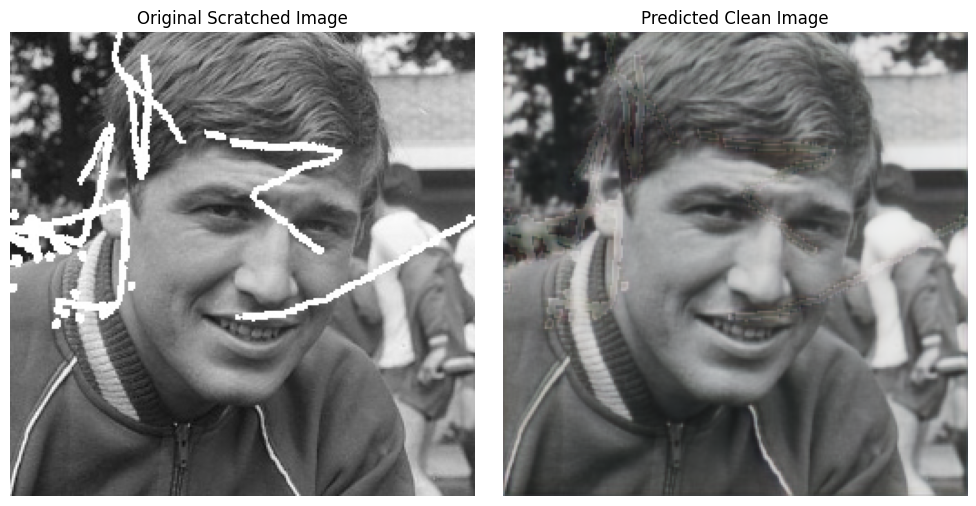

In [9]:
show_scratch_removal_comparison("/content/148.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


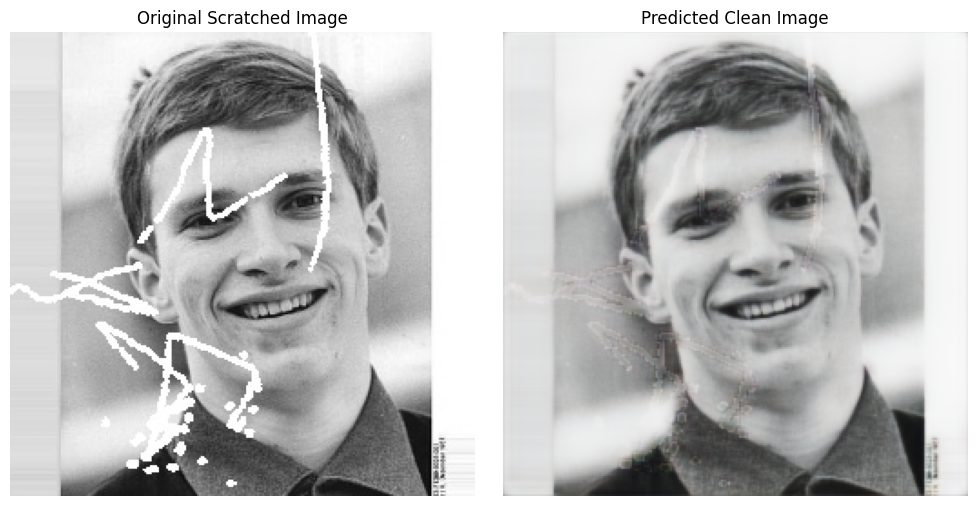

In [10]:
show_scratch_removal_comparison("/content/133.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


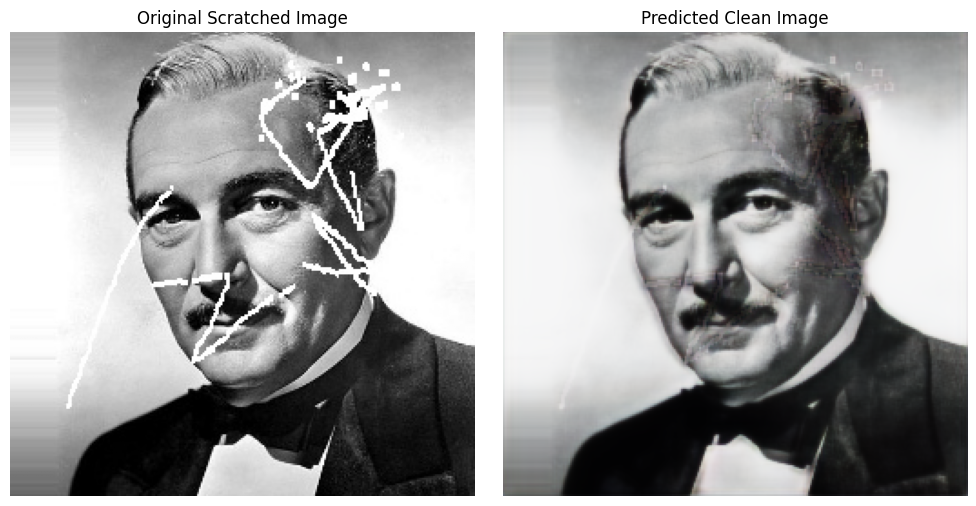

In [11]:
show_scratch_removal_comparison("/content/163.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


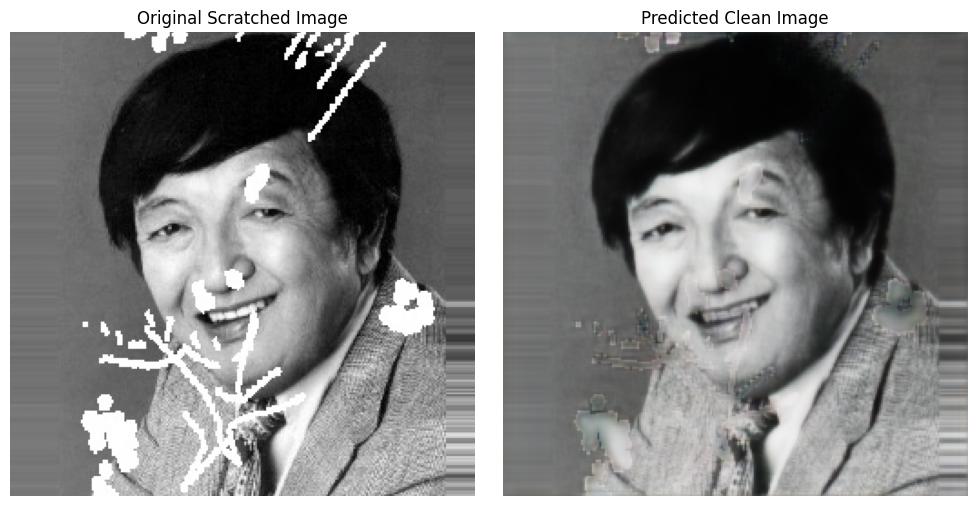

In [12]:
show_scratch_removal_comparison("/content/198.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


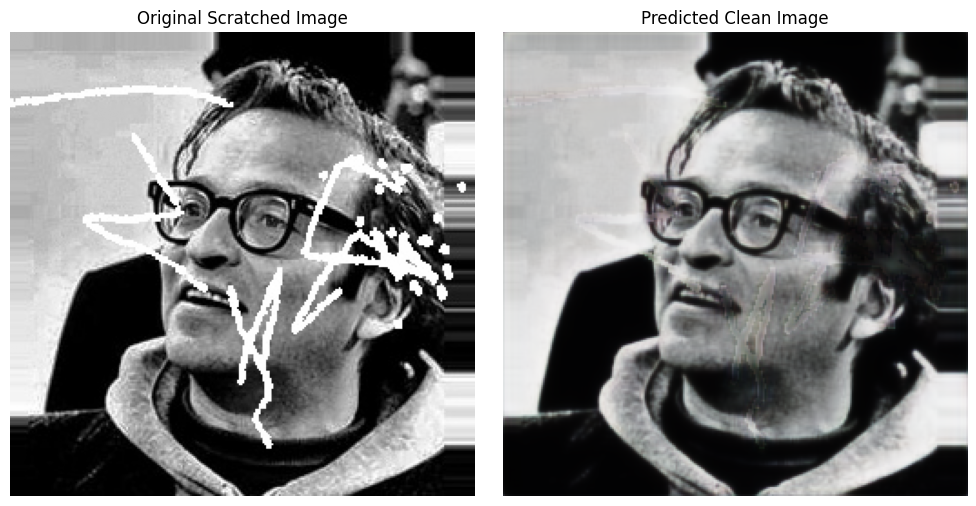

In [13]:
show_scratch_removal_comparison("/content/220.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


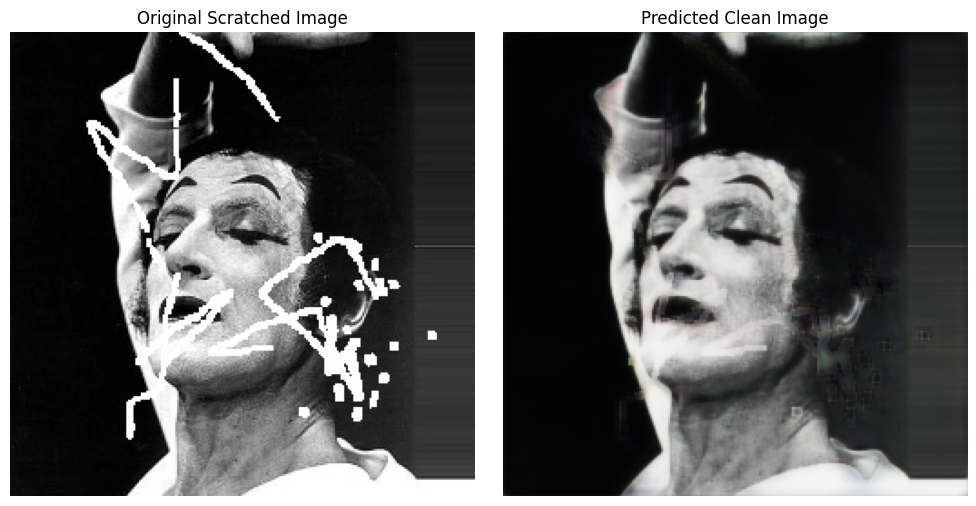

In [14]:
show_scratch_removal_comparison("/content/41.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


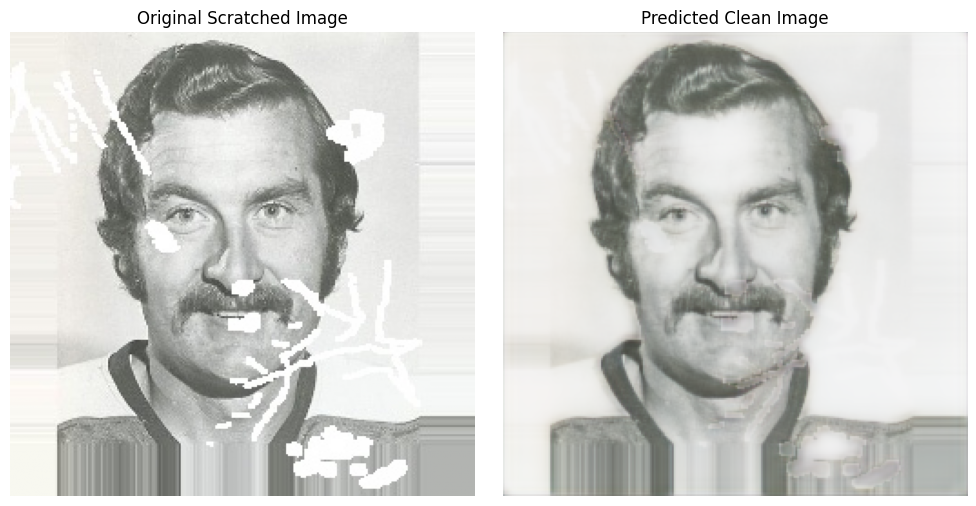

In [15]:
show_scratch_removal_comparison("/content/84.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


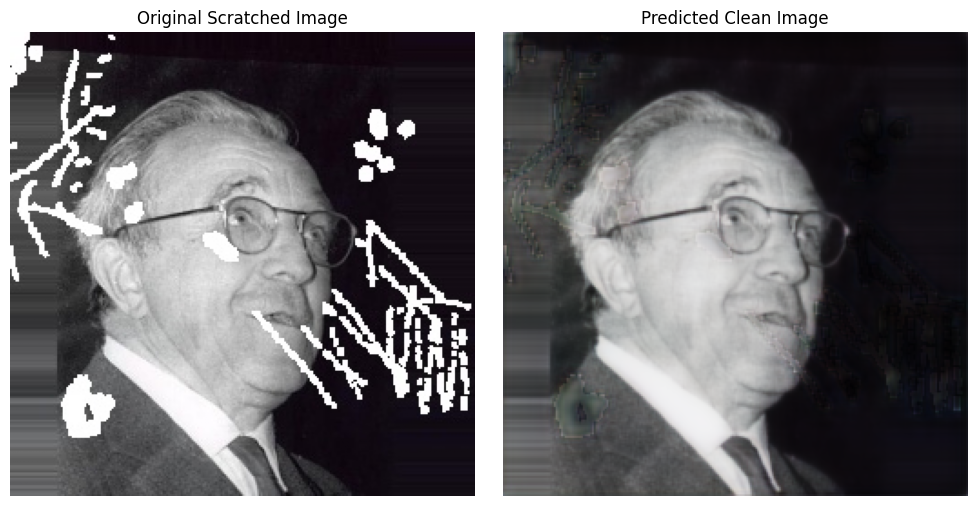

In [16]:
show_scratch_removal_comparison("/content/99.jpg", model)